# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('raw_data_test.csv')
print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean()) 

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      264540        182243  182244  B005OSC218   AJZXTZ3I9A84H   
1      146085        548350  548351  B004VLVD50  A39RNG8DUXG7ZM   
2      281714        539422  539423  B001BDDT8K  A2FRFAQCWZJT3Q   
3      280559        119141  119142  B001U0ON5M  A1YREIUL7VDQ0B   
4      236948        352256  352257  B000E63L8S  A3JKXNOLX2QRJ7   

                         ProfileName  HelpfulnessNumerator  \
0                             Jeromy                     1   
1                         W. Chapman                     4   
2        B. Davis "The Happy Hermit"                     1   
3   Jennifer U. Heston "ex-academic"                     0   
4  darlene conright "alaskan darlin"                     2   

   HelpfulnessDenominator  Score        Time                  Summary  \
0                       1      5  1316995200                 The Best   
1                       4      5  1331596800  Makes great dog bones !   
2    

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/home/ich/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/hashing.py:94: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 262144)


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
amazon['reviewLen'] = amazon['Text'].str.len()

X_quant_features = amazon[["Score", "reviewLen"]]
print(X_quant_features.head(10))
print(type(X_quant_features))

   Score  reviewLen
0      5        167
1      5        259
2      5        429
3      1        607
4      5        202
5      5        816
6      5        459
7      4        401
8      5        100
9      5        582
<class 'pandas.core.frame.DataFrame'>


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 262146)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 262146)


### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [12]:
# MODEL: logistic regression
from sklearn import linear_model

lgs = joblib.load('lgs.pkl') # pickle

lgs_performance = BinaryClassificationPerformance(lgs.predict(X), y, 'lgs')
lgs_performance.compute_measures()
print(lgs_performance.performance_measures)

{'Pos': 6588, 'Neg': 84412, 'TP': 1757, 'TN': 83900, 'FP': 512, 'FN': 4831, 'Accuracy': 0.94128571428571428, 'Precision': 0.77434993389158224, 'Recall': 0.26669702489374619, 'desc': 'lgs'}


### ROC plot to compare performance of various models and fits

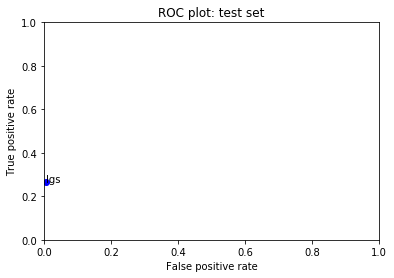

In [13]:
fits = [lgs_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()